In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import roc_curve, auc

In [4]:
original_df = pd.read_csv('default of credit card clients.csv')
data = original_df.copy()

## Data Cleaning and Preparation



### Data cleaning
*By Davis Johnson*

An intial view of the dataset suggests that:

1. The columns have been loaded in as the first row of the dataset and in capitalized letters. Both need to be fixed in order to help with the data's readability. Additionally, some columns needed to be renamed for clarity purposes. This mostly included renaming columns to include the month they were associated with.

2. An analysis of the values for the categorical columns (like education and marriage) revealed they contained some values not associated with any lables in the dataset description. For example, the marriage columns had some values that recorded as 5 or 6 even though such numbers had no significance. Any such values were replaced with the number corresponding to the "other" columns.

3. Additionally, being that the sex, marriage, and age columns are all categorical features - we decided to create dummy variables for each of their features.

The code below implements the above cleaning.

In [5]:
#Fixing Column Headings
data= data.set_axis(data.iloc[0], axis=1)
data = data.drop(data.index[0])

In [6]:
## Dropping ID since it will not be used in the analysis
data.drop(columns=['ID'], inplace=True)

In [10]:
## Making Columns Lowercase
data.columns = data.columns.str.lower()

In [11]:
## Renaming Columns for Clarity
new_names = {'pay_0': 'repay_status_sept', 'pay_2': 'repay_status_aug', 'pay_3': 'repay_status_jul', 
             'pay_4': 'repay_status_jun', 'pay_5': 'repay_status_may', 'pay_6': 'repay_status_apr',
            'bill_amt1': 'bill_sept', 'bill_amt2': 'bill_aug', 'bill_amt3': 'bill_jul', 'bill_amt4': 'bill_jun',
            'bill_amt5': 'bill_may', 'bill_amt6': 'bill_apr', 'pay_amt1': 'pay_amt_sept', 'pay_amt2': 'pay_amt_aug',
            'pay_amt3': 'pay_amt_jul', 'pay_amt4': 'pay_amt_jun', 'pay_amt5': 'pay_amt_may', 'pay_amt6': 'pay_amt_apr',
            'default payment next month': 'defaulted'}
data.rename(columns=new_names, inplace=True)

In [12]:
## Converting Columns from Object to Numeric:
# Iterate over the columns in the DataFrame
for column in data.columns:
    # Check if the column can be converted to a float
    if data[column].str.contains('\.').any():
        # If the column contains decimal points, convert it to a float
        data[column] = data[column].astype(float)
    else:
        # If the column does not contain decimal points, convert it to an integer
        data[column] = data[column].astype(int)

In [13]:
## Copying dataset to retain progress
X = data.copy()

In [14]:
## Combining Education Values 0, 5, and 6 to 4 which is classified as other
## 0,5,6 are not mentioned in dataset description
X['education'] = X['education'].replace({5: 4, 6: 4, 0: 4})

In [15]:
## Combining Marriage Value 0 with 3 which is classified as other
## 0 is not mentioned as a value in the dataset description that relates to a marriage category
X['marriage'] = X['marriage'].replace({0: 3})

In [16]:
## Encoding education, marriage, and sex since they are unordered nominal features
education_onehot = pd.get_dummies(X['education'], prefix='education')

# Rename the education columns with the corresponding education levels
education_levels = {
    'education_1': 'graduate_school',
    'education_2': 'university',
    'education_3': 'high_school',
    'education_4': 'others_education'
}
education_onehot = education_onehot.rename(columns=education_levels)

# Concatenate the one-hot encoded columns with the original DataFrame
X = pd.concat([X, education_onehot], axis=1)

# Remove the original "education" column
X = X.drop(['education'], axis=1)

marriage_onehot = pd.get_dummies(X['marriage'], prefix='marriage')

# Rename the marriage columns with the corresponding marital statuses
marital_statuses = {
    'marriage_1': 'married',
    'marriage_2': 'single',
    'marriage_3': 'others_married'
}
marriage_onehot = marriage_onehot.rename(columns=marital_statuses)

# Concatenate the one-hot encoded columns with the original DataFrame
X = pd.concat([X, marriage_onehot], axis=1)

# Remove the original "marriage" column
X = X.drop(['marriage'], axis=1)

sex_onehot = pd.get_dummies(X['sex'],prefix='sex')
sex_status = {
    'sex_1': 'sex_male',
    'sex_2': 'sex_female'
}
sex_onehot = sex_onehot.rename(columns=sex_status)
X = pd.concat([X, sex_onehot], axis=1)
X = X.drop(['sex'],axis=1)

### Data preparation
*Davis Johnson*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we will be conducting stepwise selection, one dummy level of each categorical variable was dropped to avoid issues of perfect collinearity. 

2. Since the "bill_month" columns have problematic VIF values, we decided to conduct some feature enginnering by creating a new predicot called "avg_bill_per_month" which represents the average credit card bill of each person over this six month time span. The individual "bill_month" columns were then dropped.

3. We split the dataset into a training set and testing set.

4. We have created a standardized version of the test/train datasets, as we will use it to develop Lasso regression models.

In [17]:
## Dropping one dummy level of each categorical column to avoid issues of collinearity
X = X.drop(['sex_female'],axis=1)
X = X.drop(['single'],axis=1)
X = X.drop(['graduate_school'],axis=1)

In [18]:
### Feature Engineering 

## Creating new column that represents the average credit card bill of a person over this six month span
X['avg_bill_per_month'] = (X['bill_apr']+X['bill_may']+X['bill_jun']+X['bill_jul']+X['bill_aug']+X['bill_sept'])/6

## Dropping old columns
X = X.drop(['bill_apr'],axis=1)
X = X.drop(['bill_may'],axis=1)
X = X.drop(['bill_jun'],axis=1)
X = X.drop(['bill_jul'],axis=1)
X = X.drop(['bill_aug'],axis=1)
X = X.drop(['bill_sept'],axis=1)

In [28]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X1 = X.drop('defaulted', axis=1)
y1 = X['defaulted']

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

In [29]:
## Re-adding defaulted column to train and test datasets
X_train['defaulted'] = y_train
X_test['defaulted'] = y_test

In [30]:
## Creating set of predictors to be used for stepwise selection
Xt = X_train.drop('defaulted',axis=1)

In [31]:
######-----Standardizing the datasets for Lasso-------#########
#applying a standard scaler to the data to give values more equal weight between columns
X_train_std = X_train.drop('defaulted',axis=1)
X_test_std = X_test.drop('defaulted',axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train_std), columns=X_train_std.columns)
X_test_std = pd.DataFrame(scaler.fit_transform(X_test_std), columns=X_test_std.columns)

In [32]:
## Re-adding non standardized defaulted column to the standardized datasets
X_train_std['defaulted'] = X_train['defaulted']
X_test_std['defaulted'] = X_test['defaulted']

## Exploratory data analysis
*Davis Johnson*

1. We first ran a DecisionTreeClassifier algorithm to determine an initial idea of potential important predictors.
2. We then created several boxplots (for cont. variables) and countplots (for cat. variables) to visualize any potential differences in the distributions for these variables belonging to each class. Only relevant plots were included in this section.

In [19]:
## Implementing a Decision Tree Classifier to get an Idea of Important Features
Xf = X.drop('defaulted', axis=1).values
yf = X['defaulted']
yf = yf.astype(int)

## Tree-Based estimators
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,criterion='entropy',max_depth=10)
dt.fit(Xf,yf)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [20]:
##Running Feature Importance
fi_col = []
fi = []
for i,column in enumerate(X.drop('defaulted',axis=1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

In [21]:
## Creating a dataframe
fi_df = zip(fi_col,fi)
fi_df = pd.DataFrame(fi_df,columns=['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance',ascending=False).reset_index()

,index,Feature,Feature Importance
0,2,repay_status_sept,0.453081
1,3,repay_status_aug,0.110781
2,20,avg_bill_per_month,0.072723
3,10,pay_amt_jul,0.068021
4,0,limit_bal,0.051043
5,1,age,0.040258
6,9,pay_amt_aug,0.033436
7,8,pay_amt_sept,0.030310
8,12,pay_amt_may,0.022520
9,11,pay_amt_jun,0.020907


**Based on this algorithm, the most recent repayment statuses are important in determining the probability of someone defaulting on their credit card payments in October.**

<AxesSubplot:xlabel='defaulted', ylabel='limit_bal'>

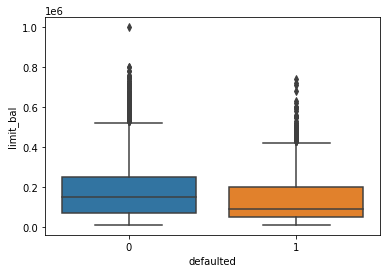

In [23]:
## Boxplot analyzing distribution of limit balance values for people who didn't and did default
sns.boxplot(x="defaulted", y="limit_bal", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_sept'>

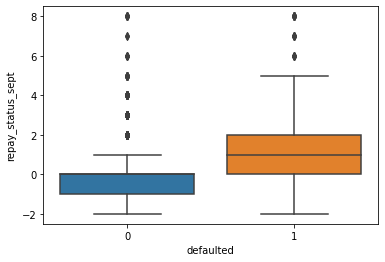

In [24]:
## Boxplot analyzing distribution of repayment statuses in September for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_sept", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_aug'>

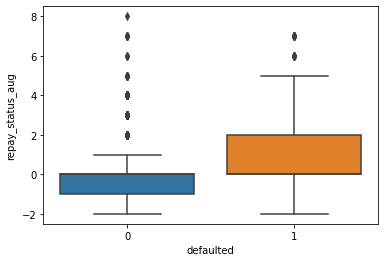

In [25]:
## Boxplot analyzing distribution of repayment statuses in August for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_aug", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_jul'>

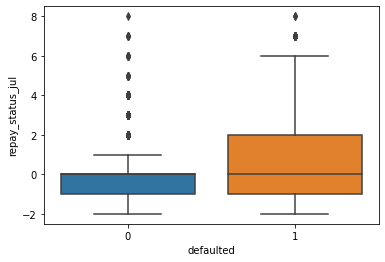

In [26]:
## Boxplot analyzing distribution of repayment statuses in July for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_jul", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_jun'>

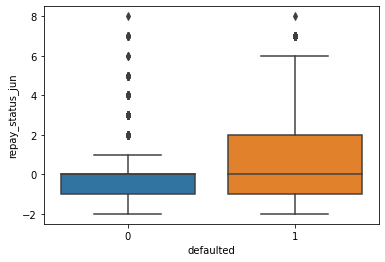

In [27]:
## Boxplot analyzing distribution of repayment statuses in June for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_jun", data=X)

**I only included the notable graphs in this report. There seems to a be general difference in the distribution of repayment statuses in many months between people who did and did not default, with people who have defaulted being generally more behind on their payments.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.